In [ ]:
import pandas as pd
import numpy as np
from numpy.random import randint, rand
from sklearn.preprocessing import scale

In [ ]:
Y = pd.read_csv('/content/WindramTrainingData.csv', index_col=[0]).T.values
mData = pd.read_csv('/content/WindramMetaData.csv', index_col=[0])

In [ ]:
#print(Y)
Y.shape

(24, 100)

In [ ]:
N, D = Y.shape
print('Time Points: %s, Genes: %s'%(N, D))

Time Points: 24, Genes: 100


In [ ]:
mData['capture'].values

array([ 6,  6,  6,  6,  6,  6, 18, 18, 18, 18, 18, 18, 30, 30, 30, 30, 30,
       30, 42, 42, 42, 42, 42, 42], dtype=int64)

In [ ]:
n_pop = N * 6
np.random.seed(10)
sigma_t = 3.
prior_mean = mData['capture'].values
print(type(prior_mean))
# N = 5
pop = [np.asanyarray([prior_mean[i] + sigma_t * np.random.randn(1) for i in range(0, N)]).reshape(-1) for _ in range(0, n_pop)]
# np.array(prior_mean).shape
#pop

<class 'numpy.ndarray'>


In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import SplineTransformer
from sklearn.metrics import mean_squared_error

# calculate akaike information criterion for a linear regression model
from math import log

def objectiveFunction(x):
    x = x[:,None]
    x_ = PolynomialFeatures(degree=3, include_bias=False).fit_transform(x)
#     x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
    
#     x_ = SplineTransformer(degree=2, n_knots=3).fit_transform(x)
    mse = 0.
    
    for i in range(0, D):
        y = Y[:,i]
        model = LinearRegression().fit(x_, y)

#         num_params = len(model.coef_) + 1
#         print('Number of parameters: %d' % (num_params))
#         print(model.coef_)

        # predict the training set
        yhat = model.predict(x_)
        # calculate the error
        mse += mean_squared_error(y, yhat)
#     print('MSE: %.3f' % mse)
    del model, y, yhat, x, x_
    bic = N * log(mse) + 3 * log(N)
    return bic

# tournament selection
def selection(pop, scores, k=3):
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

In [ ]:
sumsqr_new, sqrsum_new, sumsqr, sqrsum = sqrsum_sumsqr(30, Y)

(100, 24)
            0           1           2           3           4           5   \
0    93.074987   96.285282   97.700641   99.762601   98.089084  104.075190   
1   144.599117  154.566696  164.041429  167.652461  163.211719  166.467645   
2    46.087864   42.723733   30.953746   29.196472   32.040777   51.052241   
3    61.338558   65.365719   55.375600   61.718137   62.347058   57.745822   
4    53.712927   78.155067   70.684184   57.773295   71.055741   69.147357   
..         ...         ...         ...         ...         ...         ...   
95   51.600237   51.535022   42.813174   46.740760   50.026747   53.304700   
96   94.936845  116.351751  123.906238  144.674811  140.239109  129.637573   
97  111.807176  100.735924   84.112573   84.267524   80.022597   79.515118   
98  147.472541  145.769719  147.978707  131.906639  131.080697  147.149936   
99  100.148222  103.438247  102.720758  103.617212   94.562897   98.717064   

            6           7           8           9   .

In [ ]:
def sqrsum_sumsqr(ntest, data):
    data = np.transpose(data)
    data = pd.DataFrame(data)
    print(data.shape)
    squared = np.square(data)
    sumsqr = squared.sum(axis = 0)
    print(squared, "_", sumsqr)
    colMeans = np.mean(data, axis = 0)
    sqrsum = np.square(colMeans)
#     print(sqrsum)
#     print(sumsqr)
    #sumsqr_df = pd.DataFrame(sumsqr)
    sqrsum_df = pd.DataFrame(sqrsum)
    
    cellNumber = len(data)
    sqrsum_df *=cellNumber
    #print(sqrsum_df)
    
    ntest = ntest
    #print(ntest)
    
    sumsqr_new = pd.DataFrame()
    sqrsum_new = pd.DataFrame()
    
    for i in range(int(8*ntest)):
        sumsqr_new = pd.concat([sumsqr_new,sumsqr], axis = 1)
    print(sumsqr_new)
    
    for i in range(int(8*ntest)):
        sqrsum_new = pd.concat([sqrsum_new,sqrsum_df], axis = 1)
    print(sqrsum_new)
    return sumsqr_new, sqrsum_new, sumsqr, sqrsum

In [ ]:
# crossover two parents to create two children
def crossover(p1, p2, r_cross=0.9):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
#     print('Sumon')
#     print(c1.shape)
    # check for recombination
    if rand() < r_cross:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = np.concatenate( (p1[:pt], p2[pt:]), axis=None)
        c2 = np.concatenate( (p2[:pt], p1[pt:]), axis=None)
#         print(c1, c2)
    return [c1, c2]

# mutation operator
def mutation(offSpring, r_mut=0.05):
    sigma_mu = 2.
    for i in range(0, len(offSpring)):
        # check for a mutation
        if rand() < r_mut:
            offSpring[i] = offSpring[i] + sigma_mu * np.random.randn(1)

In [ ]:
n_iter = 200
best, best_eval = 0, objectiveFunction(pop[0])
# print(best_eval)
for gen in range (0, n_iter):
    scores = [objectiveFunction(c) for c in pop]
    for j in range(0,n_pop):
        if scores[j] < best_eval:
            best, best_eval = pop[j], scores[j]
#     print(">%d, new best f(%s) = %.3f" % (gen,  best, best_eval))
    print(">%d, new best_eval = %.3f" % (gen, best_eval))
    
    # select parents
    selected = [selection(pop, scores) for _ in range(0,n_pop)]
#     print("Selected")
#     print(len(selected))
#     print(selected)
    # create the next generation
    children = list()
    for i in range(0, n_pop, 2):
        # get selected parents in pairs
        p1, p2 = selected[i], selected[i]
        # crossover and mutation
        for c in crossover(p1, p2, r_cross=0.95):
#             # mutation
            mutation(c, r_mut=0.1)
#             # store for next generation
            children.append(c)
#     print(len(children))
#     # replace population
    pop = children
#     return [best, best_eval]
print(best, best_eval)

>0, new best_eval = 94.108
>1, new best_eval = 94.086
>2, new best_eval = 93.885
>3, new best_eval = 93.035
>4, new best_eval = 92.589
>5, new best_eval = 92.255
>6, new best_eval = 91.865
>7, new best_eval = 91.727
>8, new best_eval = 91.485
>9, new best_eval = 91.449
>10, new best_eval = 91.348
>11, new best_eval = 91.189
>12, new best_eval = 90.969
>13, new best_eval = 90.909
>14, new best_eval = 90.831
>15, new best_eval = 90.829
>16, new best_eval = 90.829
>17, new best_eval = 90.829
>18, new best_eval = 90.805
>19, new best_eval = 90.805
>20, new best_eval = 90.666
>21, new best_eval = 90.389
>22, new best_eval = 90.379
>23, new best_eval = 90.379
>24, new best_eval = 90.335
>25, new best_eval = 90.249
>26, new best_eval = 90.231
>27, new best_eval = 90.229
>28, new best_eval = 90.203
>29, new best_eval = 90.111
>30, new best_eval = 89.930
>31, new best_eval = 89.930
>32, new best_eval = 89.930
>33, new best_eval = 89.832
>34, new best_eval = 89.832
>35, new best_eval = 89.832
>3

In [ ]:
GrandPrixPseudotime = [ 2.86531809,  4.88945813,  5.96739786,  7.23224292,  7.29511602,  8.96443969,
 12.1667392,  13.0697646,  15.31346009, 15.18385335, 20.8482835,  21.97757157,
 28.11913182, 31.73585841, 33.19288584, 34.98632816, 35.81588204, 37.99144322,
 38.5310093,  39.15410389, 39.92016282, 40.13889337, 40.14194657, 40.53709647]

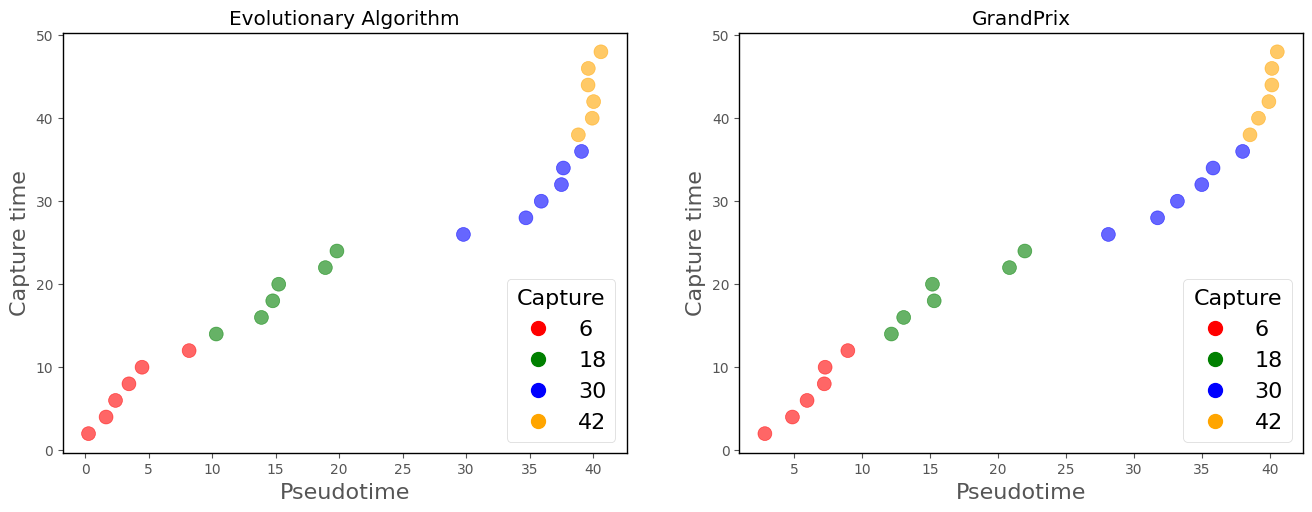

In [ ]:
from matplotlib import pyplot as plt
#from /content/utils.py import plot
actual_capture_time = mData['capture.orig'].values
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 12))
plt.subplot(2, 2, 1)
plot('Evolutionary Algorithm', 'Pseudotime', 'Capture time', best, actual_capture_time, mData['capture'].values)
plt.subplot(2, 2, 2)
plot('GrandPrix', 'Pseudotime', 'Capture time', GrandPrixPseudotime, actual_capture_time, mData['capture'].values)
plt.show()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import  numpy as np
import  pandas as pd
from collections import OrderedDict
from cycler import cycler
import warnings
warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot')
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = 'black'
# plt.rc('axes', color_cycle=['royalblue', 'orange', 'green', 'red', 'blueviolet', 'sienna', 'hotpink', 'gray', 'y', 'c'])
# plt.rc('axes', color_cycle=['royalblue', 'green', 'sienna', 'c', 'orange', 'red', 'blueviolet', 'hotpink', 'gray', 'y'])
plt.rc('axes', prop_cycle=cycler(color=['royalblue', 'green', 'sienna', 'c', 'orange', 'red', 'blueviolet', 'hotpink', 'gray', 'y']))
# axes.prop_cycle : cycler('color', ['b', 'g', 'r', 'c', 'm', 'y', 'k'])

def getari_for_latent_space(X, truelabels):
    from sklearn.cluster import KMeans
    from sklearn.metrics.cluster import adjusted_rand_score
    kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
    kmeans.labels_ = kmeans.labels_ + 1
    ARI = adjusted_rand_score(truelabels, kmeans.labels_)
    return ARI

def calcroughness(x, pt):
    x=np.atleast_2d(x)
    i=np.argsort(pt)
    x = x[:,i]
    N = x.shape[1]
    assert(N > 0)
    S = x.std(axis=1)
    return np.sqrt(np.sum(np.square(x[:,0:(N-1)] - x[:, 1:N]),1) / (N-1)) / S

def cbtime_to_tau(pTime, startTime, endTime, timeDiff):
    t = pTime * (endTime - startTime) / 100.
    t = t + (startTime + timeDiff / 2.)

    if t >= endTime:
        t = t - (endTime - startTime)
    return t


def tau_to_cbtime(tau, startTime, endTime, timeDiff):
    t = tau - (startTime + timeDiff / 2.)
    if t <= 0.:
        t = t + (endTime - startTime)
    t = t * 100. / (endTime - startTime)
    if t > 100:
        t = np.abs(100 - t)
    return t

def plot(title, xLabel, yLabel, xData, yData, cpt, xErr=None, **kwargs):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    # plt.figure(figsize=(8, 6))
    plt.title( '%s' % ( title ) )
    plt.xlabel('%s' % (xLabel), fontsize=16)
    plt.ylabel('%s' % (yLabel), fontsize=16)

    cellCapture = OrderedDict((('6', 'red'), ('18', 'green'), ('30', 'blue'), ('42', 'orange')))
    color_map = [0 for i in range(len(cpt))]

    for i in range(0, len(cpt)):
        if cpt[i] == 6:
            color_map[i] = 'red'
        elif cpt[i] == 18:
            color_map[i] = 'green'
        elif cpt[i] == 30:
            color_map[i] = 'blue'
        else:
            color_map[i] = 'orange'

    if 'datset' in kwargs:
        cellCapture = OrderedDict((('0', 'red'), ('2', 'green'), ('4', 'blue'), ('7', 'orange')))
        for i in range(0, len(cpt)):
            if cpt[i] == 1:
                color_map[i] = 'red'
            elif cpt[i] == 2:
                color_map[i] = 'green'
            elif cpt[i] == 3:
                color_map[i] = 'blue'
            else:
                color_map[i] = 'orange'

    # print(cellCapture)
    markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', ms=10, linestyle='') for color in cellCapture.values()]

    plt.scatter(xData, yData, 100, c=color_map, alpha=0.6)
    if xErr is not None:
        plt.errorbar(xData, yData, xerr=xErr, fmt='none', marker='none', ecolor=color_map)

    # l = plt.legend(markers, cellCapture.keys(), numpoints=1, title='Capture', bbox_to_anchor=(1.1, 0.5), loc=10, fontsize=16)
    l = plt.legend(markers, cellCapture.keys(), numpoints=1, title='Capture', loc=4, fontsize=16)
    plt.setp(l.get_title(), fontsize=16)
    # plt.show()

def plot_comparison(plotDf, dataset='Windram'):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'

    title = 'Comparision to the DeLorean Model'
    xLabel = 'Number of inducing points'

    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(16, 6))

    ax[0].plot(plotDf.inducingPoints, plotDf['sMean'], linestyle='--', color='r', linewidth=3.)
    ax[0].plot(plotDf.inducingPoints, plotDf['sMean'], 'rs', markersize=8)
    ax[0].plot(plotDf.inducingPoints, plotDf['sBest'], '--', color='r', linewidth=3.)
    ax[0].plot(plotDf.inducingPoints, plotDf['GPLVM_avg'], color='g', linewidth=3.)
    ax[0].plot(plotDf.inducingPoints, plotDf['GPLVM_best'], 'go', markersize=8)
    ax[0].plot(plotDf.inducingPoints, plotDf['GPLVM_best'], color='g', linewidth=3.)
    ax[0].set_ylabel('Spearman Correlation', fontsize=16)

    ax[1].plot(plotDf.inducingPoints, plotDf['timeDeLorean'], linestyle='--', color='r', linewidth=2.5)
    ax[1].plot(plotDf.inducingPoints, plotDf['GPLVM_fitting_time'], color='g', linewidth=2.5)
    ax[1].set_ylabel('Fitting time (s)', fontsize=16)

    plt.suptitle(title, fontsize=20)
    fig.text(0.5, 0.04, xLabel, ha='center', va='center', fontsize=16)
    plt.xticks(plotDf.inducingPoints)

    blue_line = mlines.Line2D([], [], color='green', linewidth=3., label='BGPLVM(Best)')
    red_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=3., label='DeLorean(Best)')
    dashed1 = mlines.Line2D([], [], color='red', marker='s', markersize=8, linestyle='--', linewidth=3.,
                            label='DeLorean(Avg)')
    dashed2 = mlines.Line2D([], [], color='green', marker='o', markersize=8, linewidth=3., label='BGPLVM(Avg)')

    l1 = plt.legend(handles=[red_line, blue_line, dashed1, dashed2], numpoints=1, bbox_to_anchor=(-0.4, 0.4), loc=10,
                    fontsize=12)

    red_line_dotted = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2.5, label='DeLorean')
    green_line_solid = mlines.Line2D([], [], color='green', linewidth=2.5, label='BGPLVM')
    l2 = plt.legend(handles=[red_line_dotted, green_line_solid], numpoints=1, bbox_to_anchor=(0.8, 0.4), loc=10,
                    fontsize=12)

    fig.gca().add_artist(l1)
    fig.gca().add_artist(l2)

def plot_fitting_time_comparison(plotDf):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.figure(figsize=(8, 8))
    plt.plot(plotDf['inducingPoints'], plotDf['timeDeLorean'], linestyle='--', linewidth=2.5, color='r')
    plt.plot(plotDf['inducingPoints'], plotDf['GPLVM_fitting_time'], linewidth=2.5, color='g')
    _ = plt.ylabel('Fitting time (s)', fontsize=16)
    _ = plt.xlabel('Number of inducing points', fontsize=16)
    _ = plt.xticks(plotDf['inducingPoints'], fontsize=12)
    _ = plt.yticks(fontsize=12)

    green_line = mlines.Line2D([], [], color='green', linewidth=2.5, label='BGPLVM')
    red_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2.5, label='DeLorean')

    _ = plt.legend(handles=[red_line, green_line], bbox_to_anchor=(1.21, 0.5), loc=10, fontsize=20, frameon=False)

def plot_genes(pseudotimes, geneProfiles, geneData, cpt, prediction):
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'Gray'
    plt.rc('xtick', labelsize=15)

    startTime = 1.
    endTime = 3.55
    timeDiff = 0.85

    selectedGenes = geneProfiles.keys().values
    cbPeaktime = np.zeros(len(selectedGenes))
    for g in range(0, len(selectedGenes)):
        cbPeaktime[g] = cbtime_to_tau(geneData[selectedGenes[g]].cbPeaktime, startTime, endTime, timeDiff)
        # print(geneData[selectedGenes[g]].cbPeaktime)

    Xnew = prediction[0]
    meanDf = prediction[1]
    varDf = prediction[2]
    # Create a Dataframe to contain predictive mean and variance
    predictDf = {}
    for i in range(len(selectedGenes)):
        predictDf[selectedGenes[i]] = pd.DataFrame({'mean': meanDf[selectedGenes[i]], 'var': varDf[selectedGenes[i]]})

    # Plot the result
    title = 'McDavid'
    xLabel = 'Pseudotime'
    yLabel = 'Expression'

    fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 8))

    # plt.suptitle(title, fontsize=16)
    fig.text(0.5, -0.04, xLabel, ha='center', va='center', fontsize=20)
    fig.text(0.04, 0.5, yLabel, ha='center', va='center', rotation='vertical', fontsize=20)

    xValues = np.array([1., 1.85, 2.7, 3.55])
    xString = np.array(['G2/M', 'G0/G1', 'S', 'G2/M'])
    plt.xticks(xValues, xString)
    plt.xlim(1., 3.55)

    # Following codes are used just to add legends
    cellCycleStages = {'g0/g1': u'red', 's': u'green', 'g2/m': u'blue'}
    stageColorCodes = ['red', 'green', 'blue']
    color_map = [stageColorCodes[cpt[i] - 1] for i in range(len(cpt))]
    markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', markersize=9, linestyle='') for color in
               cellCycleStages.values()]
    l = plt.legend(markers, cellCycleStages.keys(), numpoints=1, title='Capture Stages', bbox_to_anchor=(1.6, 1.1),
                   loc=10, fontsize=20, frameon=False)
    plt.setp(l.get_title(), fontsize=20)

    n = 0
    for row in ax:
        for col in row:
            col.plot(Xnew[:, 0], predictDf[selectedGenes[n]]['mean'].values, 'black', lw=1)
            col.fill_between(Xnew[:, 0], predictDf[selectedGenes[n]]['mean'].values - \
                             2 * np.sqrt(predictDf[selectedGenes[n]]['var'].values),
                             predictDf[selectedGenes[n]]['mean'].values + \
                             2 * np.sqrt(predictDf[selectedGenes[n]]['var'].values), color='grey', alpha=0.5)
            col.scatter(pseudotimes, geneProfiles[selectedGenes[n]], 130, marker='.', c=color_map, alpha=0.6)
            col.set_title(selectedGenes[n], fontsize=16)
            col.axvline(cbPeaktime[n], linestyle='--', color='black')
            plt.setp(col.xaxis.get_majorticklabels(), rotation=90)
            col.yaxis.set_tick_params(labelsize=14)
            n = n + 1

def plotcorrelation(X, Y, title, data_labels):
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.rcParams['axes.edgecolor'] = 'black'
    # plt.rc('axes', color_cycle=['royalblue', 'orange', 'green', 'red', 'blueviolet', 'sienna', 'hotpink', 'gray', 'y', 'c'])

    legend_order = ['1', '2', '4', '8', '16', '32 ICM', '32 TE', '64 PE', '64 TE', '64 EPI']
    # label_order = ['1', '16', '2', '32 ICM', '32 TE', '4', '64 PE', '64 TE', '64 EPI', '8']
    yVals = np.array([1, 2, 4, 8, 16, 24, 32])
    yStrings = np.array(['1', '2', '4', '8', '16', '32', '64'])

    for l in legend_order:
        x = Y[data_labels == l]
        if x[0]==64.:
            x = [x[i] - 32 for i in range(0,len(x))]
        elif x[0] == 1.:
            x = [x[i] - 0. for i in range(0, len(x))]
        elif x[0] == 4.:
            x = [x[i] + 0. for i in range(0, len(x))]
        elif x[0] == 32.:
            x = [x[i] - 8. for i in range(0, len(x))]

        plt.scatter(X[data_labels == l], x, 100, label=l)
        plt.tick_params(labelsize=14)
        plt.yticks(yVals, yStrings)
        plt.xlabel('Pseudotime', fontsize = 20)
        plt.ylabel('Capture time', fontsize=20)
        plt.title(title, fontsize=20)
        l = plt.legend(loc="lower right", fontsize=14, ncol=2, title="Capture stages", borderaxespad=0., columnspacing=0.2, handletextpad=0.1)
        plt.setp(l.get_title(), fontsize=16)

def plot_XY(X, Y, title, data_labels, label_order=None, **kwargs):
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.rcParams['axes.edgecolor'] = 'black'
    # plt.rc('axes', color_cycle=['royalblue', 'orange', 'green', 'red', 'blueviolet', 'sienna', 'hotpink', 'gray', 'y', 'c'])

    if label_order is None:
        label_order = ['1', '2', '4', '8', '16', '32 ICM', '32 TE', '64 PE', '64 TE', '64 EPI']

    mSize = 100
    if 'ms' in kwargs:    mSize = kwargs.pop('ms')

    fsize = 16
    if 'fontsize' in kwargs:    fsize = kwargs.pop('fontsize')

    for l in label_order:
        plt.scatter(X[data_labels == l], Y[data_labels == l], mSize, label=l)
        xPos = np.median(X[data_labels == l])
        yPos = np.median(Y[data_labels == l])
        # if title != 'With prior' and l == '32 TE':
        #     xPos = xPos - 0.4
        # if title == 'With prior' and l == '64 TE':
        #     xPos = xPos + 0.2
        plt.text(xPos, yPos, l, fontsize=fsize, weight='bold')

    xlabel = 'GPLVM-1 (Pseudotime)'
    ylabel = 'GPLVM-2'
    if 'xlabel' in kwargs:  xlabel = kwargs.pop('xlabel')
    if 'ylabel' in kwargs:  ylabel = kwargs.pop('ylabel')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)

def correlation_dpt(xData, yData, cpt, ax, title, diagLine=False):
    cellCapture = OrderedDict((('0','red'), ('2','green'), ('4','blue'), ('7','orange')))
    color_map = [0 for i in range(len(cpt))]

    for i in range(0,len(cpt)):
        if cpt[i] == 1:
            color_map[i] = 'red'
        elif cpt[i] == 2:
            color_map[i] = 'green'
        elif cpt[i] == 3:
            color_map[i] = 'blue'
        else:
            color_map[i] = 'orange'

    markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in cellCapture.values()]

    # plt.figure(figsize=(5, 5))
    ax.scatter(xData, yData, 10, c=color_map)
    if diagLine:
        ax.plot( [0,0.7],[0,0.7], linewidth=3)
    _=plt.xticks(fontsize=14)
    _=plt.yticks(fontsize=14)
    ax.set_xlabel('BGPLVM Pseudotime', fontsize=16)
    ax.set_ylabel('Diffusion Pseudotime', fontsize=16)
    ax.set_title(title, fontsize=18)
    # plt.title("Correlation (No Prior) = %f"%(spearmanr(pTimes['pt_np_32_trun'].values, pTimes['dpt'].values)[0]), fontsize=20)
    # plt.xlabel('BGPLVM', fontsize=20)
    # plt.ylabel('DPT', fontsize=20)
    # l = plt.legend(markers, cellCapture.keys(), numpoints=1, title='Capture', bbox_to_anchor=(1.15, 0.5), loc=10, fontsize=16)
    ax.legend(markers, cellCapture.keys(), numpoints=1, title='Capture', fontsize=14, frameon=False)
    # ax.setp(l.get_title(), fontsize=14)

def plot_robustness_across_prior_variance(array_of_values, single_value, title, xlabel, ylabel):
    xVals = np.array([0.01, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])
    xStrings = np.array(['0.01', '0.1', '0.2', '0.5', '0.8', '1.', '1.5', '2.', '3.', '5.', '10.', '25.', '50.', '100.', 'No Prior'])

    plt.scatter(xVals, array_of_values, linewidth=5)
    plt.plot(xVals, array_of_values, linewidth=4)

    plt.ylim([0., 1.0])

    plt.xticks(np.append(xVals, 70), xStrings, rotation=90, fontsize=16)
    plt.yticks(fontsize=14)

    plt.axvline(x=5, ymax=array_of_values[1], linestyle='--', linewidth=5, c='black')
    plt.scatter(70, single_value, linewidth=5, c='red')
    plt.axvline(x=70, ymax=single_value, linestyle='--', linewidth=5, c='red')

    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.title(title, fontsize=20)

In [ ]:
from scipy import stats
print(stats.spearmanr(best, GrandPrixPseudotime))

SignificanceResult(statistic=0.9913043478260868, pvalue=7.113899561244949e-21)
